In [1]:
#Import libraries
import ee
import pandas as pd
import geemap

# Trigger ee authentication 
ee.Authenticate()
 
# # Initializeee library
ee.Initialize()

- classification accuracy metrics for general and individual classes
- year land cover maps
- statistics for the land size of classes covered
- methodoly explanation of the graph convolutional network
- models 
- regerate data visaulisation and statistical metrics for the training satellite data

    project/
      ├── data/
      │   ├── landsat_accra.tif
      │   ├── osm_graph_accra.gpickle
      ├── scripts/
      │   ├── preprocess_grid.py
      │   ├── preprocess_osm.py
      │   ├── model.py
      │   ├── train.py
      ├── results/
      ├── README.md
    

In [2]:
import os
print(os.environ['CONDA_DEFAULT_ENV'])

geo_gcn_env


In [3]:
import rasterio
import geopandas as gpd
import numpy as np
from rasterio.plot import show
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import networkx as nx
from shapely.geometry import box
from rasterio.warp import transform_bounds
from pyproj import CRS
import matplotlib.pyplot as plt
from rasterstats import zonal_stats
import osmnx as ox

In [4]:
#Setting ROI (Region of Interest)
# imageROI = ee.Geometry.Rectangle(-1.5493322237426321,6.4533743404043244,-1.4198995455199759,6.561506439869568) #Polygon surrounding the Techiman area
imageROI = ee.Geometry.Rectangle(-1.5880583877622567,6.157655377979639,-1.7260741348325692,6.253563761708023)
location = imageROI.centroid().coordinates().getInfo()[::-1] #Getting the centroid location inside the polygon for centering in Map

In [5]:
# Get centroid for map centering (optional)
location = imageROI.centroid().coordinates().getInfo()[::-1]

def mask_s2_clouds(image):
    """Masks clouds in a Sentinel-2 image using the QA band.

      Args:
          image (ee.Image): A Sentinel-2 image.

      Returns:
      ee.Image: A cloud-masked Sentinel-2 image.
    """
    qa = image.select('QA60')

    # Bits 10 and 11 are clouds and cirrus, respectively.
    cloud_bit_mask = 1 << 10
    cirrus_bit_mask = 1 << 11

    # Both flags should be set to zero, indicating clear conditions.
    mask = (
      qa.bitwiseAnd(cloud_bit_mask)
      .eq(0)
      .And(qa.bitwiseAnd(cirrus_bit_mask).eq(0))
)

    return image.updateMask(mask).divide(10000)


# Apply cloud mask to each image
sentinel = (
    ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') 
    .filterBounds(imageROI) 
    .filterDate('2021-01-01', '2021-03-31') 
    # Pre-filter to get less cloudy granules.
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)) 
    .map(mask_s2_clouds) 
    .median()
)


# Select bands (e.g., Blue, Green, Red, NIR)
bands = ['B2', 'B3', 'B4', 'B8']
image = sentinel.select(bands)

# Clip to the rectangle region (NOT district)
clipped = image.clip(imageROI)

In [6]:
clipped

In [7]:
Map = geemap.Map()

In [8]:
# Set up the geemap Map
Map = geemap.Map(center=location, zoom=12)
Map.addLayer(clipped, {
    'bands': ['B4', 'B3', 'B2'],  # RGB visualization
    'min': 0,
    'max': 0.3
}, 'Clipped Sentinel-2 Image (Kumasi)')

# Optionally add the ROI outline
Map.addLayer(imageROI, {}, 'ROI Boundary')

# Display the map
Map

Map(center=[6.205612580995451, -1.6570662612959666], controls=(WidgetControl(options=['position', 'transparent…

In [9]:
# Optional: Export
geemap.ee_export_image(
    clipped, filename='obuasi.tif', scale=10, region=imageROI, file_per_band=False
)

print("Image prepared and clipped to Techiman region!")


Generating URL ...
Please wait ...
Data downloaded to C:\Users\gsamu\Graph Conv\obuasi.tif
Image prepared and clipped to Techiman region!


####  Downloading Sentinel data

### Get  land cover labels using Esri

In [10]:
# Load ESRI Global Land Cover dataset
# lc = ee.ImageCollection("projects/sat-io/open-datasets/landcover/ESRI_Global-LULC_10m_TS") \
#     .mosaic() \
#     .clip(imageROI)

# # Select the label band (usually only one band)
# label = lc.select('b1')


In [11]:
# # Export label image
# geemap.ee_export_image(
#     label, 
#     filename='./esri_landcover_obuasi_label.tif',
#     scale=10, 
#     region=imageROI,
#     file_per_band=False
# )

In [12]:
Map = geemap.Map()
# Define a dictionary which will be used to make legend and visualize image on map
dict_legend = {
  "names": [
    "Water",
    "Trees",
    "Flooded Vegetation",
    "Crops", 
    "Built Area",
    "Bare Ground",
    # "Snow/Ice",
    # "Clouds",  
    # "Rangeland"
  ],
  
  "colors": [
    "#1A5BAB",
    "#358221",
    "#87D19E",
    "#FFDB5C",
    "#ED022A",
    "#EDE9E4",
    # "#F2FAFF",
    # "#C8C8C8",
    # "#C6AD8D"  
  ]}

In [13]:
# Load ESRI Global LULC 10m Time Series
esri_lulc10 = ee.ImageCollection("projects/sat-io/open-datasets/landcover/ESRI_Global-LULC_10m_TS")

# Remap function: maps ESRI class values to sequential class IDs (1–9)
def remapper(image):
    return image.remap([1, 2, 4, 5, 7, 8, 9, 10, 11],
                       [1, 2, 3, 4, 5, 6, 7, 8, 9]).rename('landcover')

# Filter for 2017 and mosaic
lulc_2017 = esri_lulc10.filterDate('2018-01-01', '2018-12-31').mosaic().clip(imageROI)
lulc_2017_remapped = remapper(lulc_2017)

# Print to confirm
lulc_2017_remapped

In [56]:
# Export label image
geemap.ee_export_image(
    lulc_2017_remapped, 
    filename='./esri_landcover_obuasi_label.tif',
    scale=10, 
    region=imageROI,
    file_per_band=False
)

Generating URL ...
Please wait ...
Data downloaded to C:\Users\gsamu\Graph Conv\esri_landcover_obuasi_label.tif


In [14]:
# Visualization dictionary
esri_viz = {
    'min': 1,
    'max': 6,
    'palette': [
        "#1A5BAB",  # Water
        "#358221",  # Trees
        "#87D19E",  # Flooded Vegetation
        "#FFDB5C",  # Crops
        "#ED022A",  # Built Area
        "#EDE9E4",  # Bare ground
        # "#F2FAFF",  # Snow/Ice
        # "#C8C8C8",   # Clouds
        # "#C6AD8D"
    ]
}

In [15]:
# Create map and add layer
# Map = geemap.Map(center=[6.6, -1.7], zoom=10)
# Set up the geemap Map
Map = geemap.Map(center=location, zoom=12)
Map.addLayer(clipped, {
    'bands': ['B4', 'B3', 'B2'],  # RGB visualization
    'min': 0,
    'max': 0.3
}, 'Clipped Sentinel-2 Image (Kumasi)')

# Optionally add the ROI outline
Map.addLayer(imageROI, {}, 'ROI Boundary')
Map.addLayer(lulc_2017_remapped, esri_viz, "ESRI Landcover")
Map.add_legend(title="ESRI Land Cover Legend", labels=dict_legend["names"], colors=dict_legend["colors"])
display(Map)


Map(center=[6.205612580995451, -1.6570662612959666], controls=(WidgetControl(options=['position', 'transparent…

In [12]:
# predicted_map.unique()

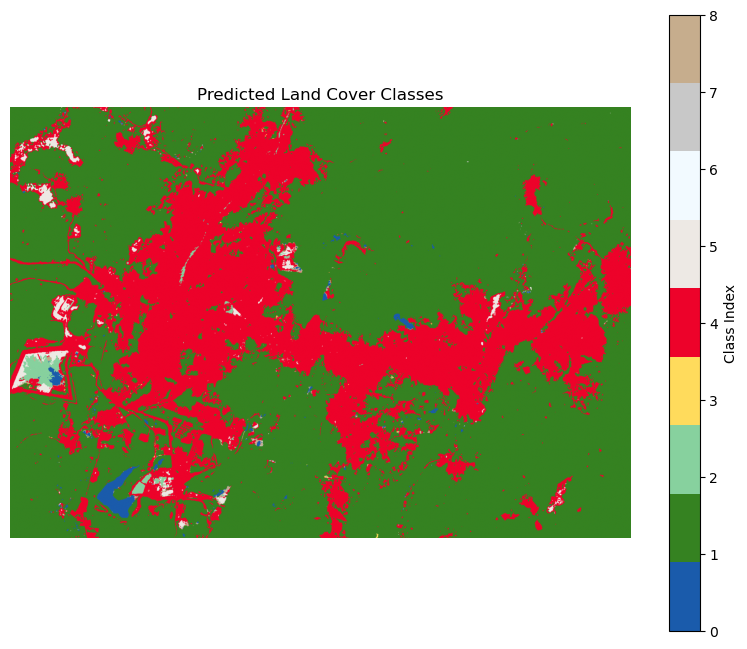

In [40]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Define custom color codes
custom_colors = [
    "#1A5BAB",  # 0: Water
    "#358221",  # 1: Trees
    "#87D19E",  # 2: Flooded Vegetation
    "#FFDB5C",  # 3: Crops
    "#ED022A",  # 4: Built Area
    "#EDE9E4",   # 5: Bare Ground
    "#F2FAFF",  # Snow/Ice
    "#C8C8C8",   # Clouds
    "#C6AD8D"
]

# Create a colormap
cmap = ListedColormap(custom_colors)
plt.figure(figsize=(10, 8))
plt.imshow(predicted_map, cmap=cmap)
plt.title("Predicted Land Cover Classes")
plt.axis('off')
cbar = plt.colorbar(ticks=range(len(custom_colors)))
cbar.set_label('Class Index')
plt.show()

#### Add extra bands to data

In [11]:
# Compute and add a single band (NDVI).
ndvi = clipped.normalizedDifference(['B8', 'B4']).rename('NDVI')
clipped = clipped.addBands(ndvi)

In [12]:
# Add landcover from esri as another band
clipped = clipped.addBands(lulc_2017_remapped)

In [13]:
lulc_2017_remapped.getInfo()

{'type': 'Image',
 'bands': [{'id': 'landcover',
   'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 1, 'max': 9},
   'dimensions': [2, 2],
   'origin': [-3, 5],
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]}],
 'properties': {'system:footprint': {'type': 'Polygon',
   'coordinates': [[[-1.7260741348325692, 6.157655377979639],
     [-1.5880583877622567, 6.157655377979639],
     [-1.5880583877622567, 6.253563761708023],
     [-1.7260741348325692, 6.253563761708023],
     [-1.7260741348325692, 6.157655377979639]]]}}}

In [21]:
# Download the data
# Optional: Export
geemap.ee_export_image(
    clipped, filename='sentinel_obuasi_landcover_new.tif', scale=10, region=imageROI, file_per_band=False
)

print("Image prepared and clipped to Obuasi region!")


Generating URL ...
Please wait ...
Data downloaded to C:\Users\gsamu\Graph Conv\sentinel_obuasi_landcover_new.tif
Image prepared and clipped to Obuasi region!


In [6]:
out_image = 'sentinel_obuasi_landcover_new.tif'
# Read raster
with rasterio.open(out_image) as src:
    img = src.read()
    transform = src.transform
    width, height = src.width, src.height

In [7]:
img[:, :, :].shape

(6, 1069, 1537)

In [18]:
normal_bands = img[:5, :, :] # e.g., B2, B3, B4, B8, NDVI, Landcover
labels = img[-1, :, :]
normal_bands.shape[0]
band_names = ["B2", "B3", "B4", "B8", "NDVI"]

In [30]:
class_mapping = {
    1: "Water",
    2: "Trees",
    3: "Flooded Vegetation",
    4: "Crops",
    5: "Built Area",
    6: "Bare Ground",
    7: "Snow Ice",
    8: "Clouds",
    9: "Rangeland"
}


In [12]:
def plot_individual_bands(image_array, band_names):
    """Plots each individual band in grayscale."""
    num_bands = image_array.shape[0]
    plt.figure(figsize=(15, 4))
    for i in range(num_bands):
        plt.subplot(1, num_bands, i + 1)
        band = image_array[i, :, :]  # Correctly select the (height, width) band
        plt.imshow(band, cmap='gray')
        plt.title(band_names[i])
        plt.axis('off')
    plt.suptitle('Individual Sentinel-2 Bands')
    plt.tight_layout()
    plt.show()

def plot_pixel_histograms(image_array, band_names):
    """Plots the histogram of pixel intensities for each band."""
    plt.figure(figsize=(10, 6))
    for i in range(image_array.shape[0]):
        plt.hist(image_array[i, :, :].ravel(), bins=100, alpha=0.5, label=band_names[i])
    plt.title("Pixel Value Distribution per Band")
    plt.xlabel("Pixel Value")
    plt.ylabel("Frequency")
    plt.legend()
    plt.tight_layout()
    plt.show()


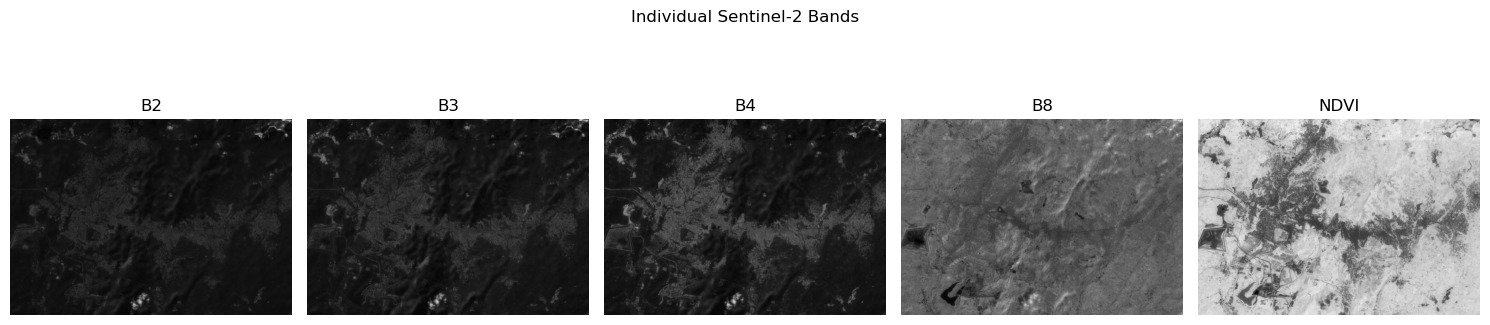

In [13]:
plot_individual_bands(normal_bands, band_names)

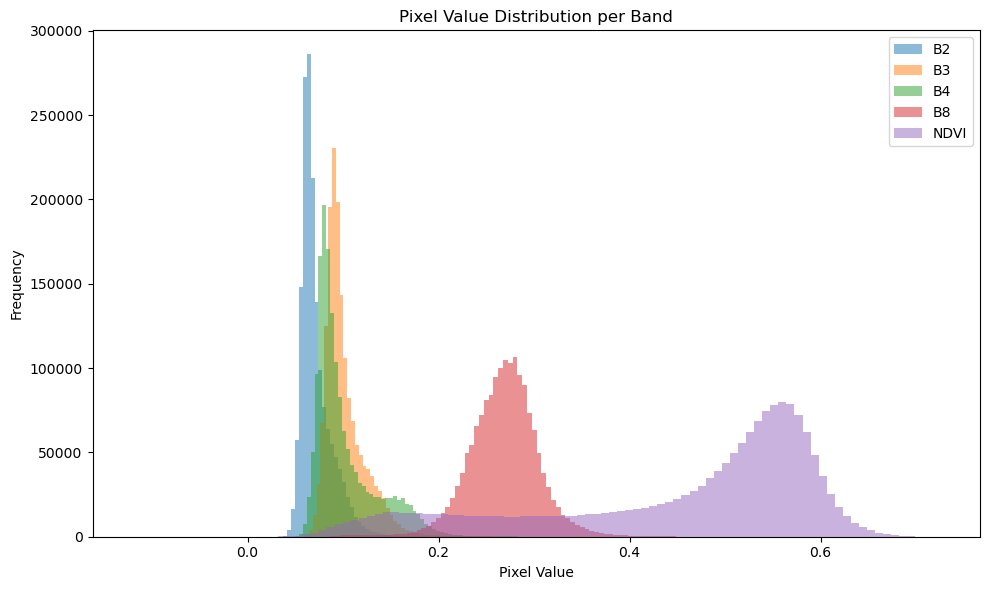

In [14]:
plot_pixel_histograms(normal_bands, band_names)


In [27]:
labels

array([[2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       ...,
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.]], shape=(1069, 1537), dtype=float32)

In [28]:
def plot_class_distribution(label_array, class_mapping):
    """Plots the class distribution based on pixel counts."""
    unique, counts = np.unique(label_array, return_counts=True)
    # class_labels = [class_mapping.get(cls, f"Class {cls}") for cls in unique]

    vectorized_map = np.vectorize(lambda cls: class_mapping.get(cls, f"Class {cls}"))
    class_labels = vectorized_map(unique)

    plt.figure(figsize=(10, 6))
    plt.bar(class_labels, counts, color='skyblue')
    plt.title("Land Cover Class Distribution")
    plt.xlabel("Land Cover Class")
    plt.ylabel("Pixel Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


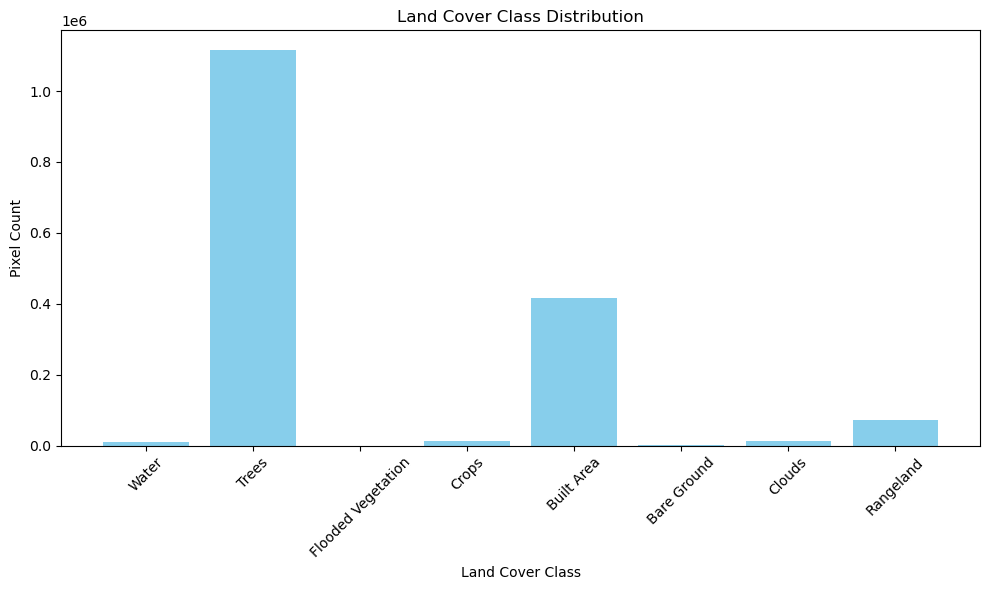

In [31]:
plot_class_distribution(labels, class_mapping)

In [36]:
import seaborn as sns

In [37]:
def plot_band_correlation(image_array, band_names):
    """Plots a correlation matrix between bands."""
    reshaped = image_array.reshape(-1, image_array.shape[0])
    df = pd.DataFrame(reshaped, columns=band_names)
    corr = df.corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr, annot=True, cmap='coolwarm')
    plt.title("Band Correlation Matrix")
    plt.tight_layout()
    plt.show()

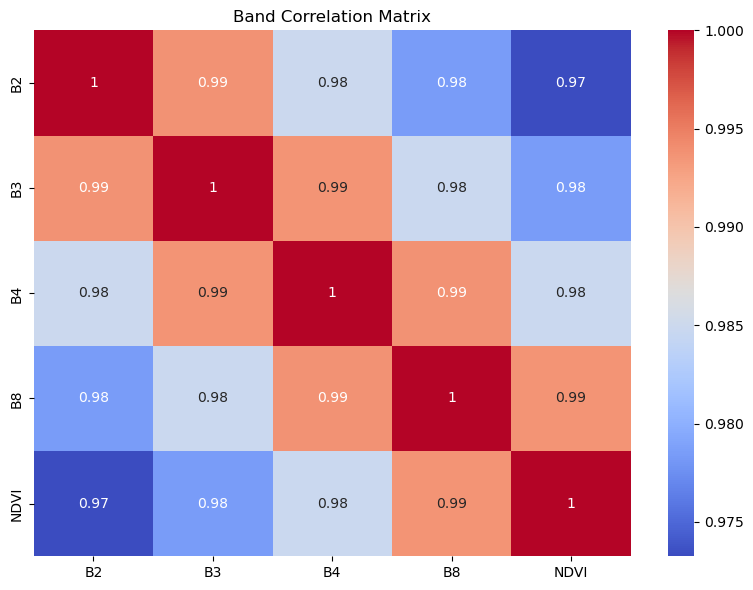

In [38]:
plot_band_correlation(normal_bands, band_names)

In [7]:
from visualisations import *

In [10]:

# Example usage (you can comment these out when integrating):
# if __name__ == "__main__":
#     normal_bands = img[:5, :, :] # e.g., B2, B3, B4, B8, NDVI, Landcover
#     band_names = ["B2", "B3", "B4", "B8", "NDVI"]
#     labels = img[:-1, :, :]
#     class_mapping = {
#         0: "Water",
#         1: "Trees",
#         2: "Flooded Vegetation",
#         3: "Crops",
#         4: "Built Area",
#         5: "Bare Ground"
#     }

    plot_individual_bands(normal_bands, band_names)
    # plot_pixel_histograms(normal_bands, band_names)
    # plot_class_distribution(labels, class_mapping)
    # plot_ndvi_histogram(normal_bands[:, :, -1])  # Assuming NDVI is last
    # show_rgb(normal_bands, bands_indices=(2, 1, 0))
    # plot_band_correlation(normal_bands, band_names)


## Graph Representation 

### Approach 1: Using Grid based Graph Construction

In [7]:
# !pip install torch_geometric

In [33]:
import rasterio
from rasterio.plot import show
import numpy as np

In [34]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import networkx as nx

In [5]:
img.shape

(4, 1079, 1155)

In [17]:
# Reshape bands
bands_data = np.moveaxis(img, 0, -1)  # (height, width, bands)
# Flatten spatial dimensions
features = bands_data.reshape(-1, bands_data.shape[2])  # (nodes, features)

# Normalize
features = (features - features.mean(axis=0)) / (features.std(axis=0) + 1e-8)
features = torch.tensor(features, dtype=torch.float)

In [18]:
bands_data.shape

(1079, 1155, 4)

In [19]:
# Build adjacency (4-neighbors)
G = nx.grid_2d_graph(height, width)  # simple 4-connectivity
mapping = {(i, j): i * width + j for i in range(height) for j in range(width)}
G = nx.relabel_nodes(G, mapping)
edges = list(G.edges)
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

In [20]:
# Dummy labels (real case: use manually annotated labels or classify unsupervised clusters)
num_classes = 9
labels = torch.randint(0, num_classes, (features.shape[0],), dtype=torch.long)

# PyG Data
data = Data(x=features, edge_index=edge_index, y=labels)

print(data)

Data(x=[1246245, 4], edge_index=[2, 2490256], y=[1246245])


In [21]:
data

Data(x=[1246245, 4], edge_index=[2, 2490256], y=[1246245])

In [22]:
import rasterio
import geopandas as gpd
from shapely.geometry import box
from rasterio.warp import transform_bounds
from pyproj import CRS
import matplotlib.pyplot as plt

def generate_grid_from_raster(raster_path, cell_size=30, grid_crs='EPSG:32630', to_wgs84=True):
    # Step 1: Open the raster and get bounds
    with rasterio.open(raster_path) as src:
        original_crs = src.crs
        bounds = src.bounds

        print(f"[INFO] Original CRS: {original_crs}")
        
        # Step 2: Reproject bounds to grid_crs (e.g., UTM)
        bounds_projected = transform_bounds(original_crs, grid_crs, *bounds)

    # Step 3: Create grid using projected coordinates
    minx, miny, maxx, maxy = bounds_projected
    cols = int((maxx - minx) // cell_size)
    rows = int((maxy - miny) // cell_size)

    print(f"[INFO] Grid dimensions: {rows} rows x {cols} cols")

    grid_polygons = []
    for row in range(rows):
        for col in range(cols):
            x1 = minx + col * cell_size
            y1 = miny + row * cell_size
            x2 = x1 + cell_size
            y2 = y1 + cell_size
            grid_polygons.append(box(x1, y1, x2, y2))

    grid_gdf = gpd.GeoDataFrame({'geometry': grid_polygons}, crs=grid_crs)

    # Step 4: Optionally reproject back to WGS84 for visualization/export
    if to_wgs84:
        grid_gdf = grid_gdf.to_crs("EPSG:4326")

    return grid_gdf


In [23]:
geotif_location = 'sentinel2_kumasi.tif'
grid_gdf = generate_grid_from_raster(geotif_location, cell_size=30)

[INFO] Original CRS: EPSG:4326
[INFO] Grid dimensions: 358 rows x 383 cols


### Adding the labels 

In [28]:
!pip install rasterstats --quietz

In [29]:
from rasterstats import zonal_stats

stats = zonal_stats(grid_gdf, "esri_landcover_kumasi_label.tif", stats=['majority'], categorical=True)
grid_gdf['label'] = [s.get('majority', -1) for s in stats]


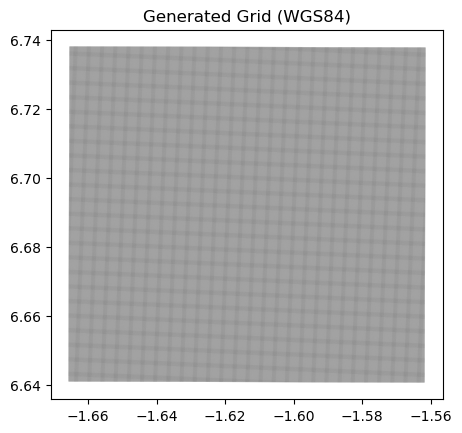

In [30]:

# Visualize
grid_gdf.plot(edgecolor='gray', facecolor='none', linewidth=0.2)
plt.title("Generated Grid (WGS84)")
plt.show()


In [31]:
grid_gdf

,geometry,label
0,"POLYGON ((-1.66547 6.64107, -1.66547 6.64134, ...",NaN
1,"POLYGON ((-1.6652 6.64106, -1.6652 6.64134, -1...",5.0
2,"POLYGON ((-1.66493 6.64106, -1.66492 6.64134, ...",5.0
3,"POLYGON ((-1.66465 6.64106, -1.66465 6.64133, ...",5.0
4,"POLYGON ((-1.66438 6.64106, -1.66438 6.64133, ...",5.0
...,...,...
137109,"POLYGON ((-1.56262 6.73763, -1.56262 6.7379, -...",5.0
137110,"POLYGON ((-1.56235 6.73763, -1.56235 6.7379, -...",5.0
137111,"POLYGON ((-1.56208 6.73763, -1.56208 6.7379, -...",5.0
137112,"POLYGON ((-1.56181 6.73763, -1.56181 6.7379, -...",5.0


### Save and export grid

In [35]:
grid_fc = ee.FeatureCollection('projects/nigtroy/assets/grid')

In [38]:
Map = geemap.Map(center=location, zoom=12)
Map.addLayer(clipped, {
    'bands': ['B4', 'B3', 'B2'],  # RGB visualization
    'min': 0,
    'max': 0.3
}, 'Clipped Sentinel-2 Image (Kumasi)')

# Optionally add the ROI outline
Map.addLayer(imageROI, {}, 'ROI Boundary')
# Add Grid Overlay
Map.addLayer(grid_fc, {}, "Grid")
Map.addLayer(lulc_2017_remapped, esri_viz, "ESRI Landcover")
Map.add_legend(title="ESRI Land Cover Legend", labels=dict_legend["names"], colors=dict_legend["colors"])
display(Map)



Map(center=[6.689560394047556, -1.6136245238872227], controls=(WidgetControl(options=['position', 'transparent…

### Extracting Labels per Grid

In [47]:
# Add label to each grid cell using mode (most common pixel)
labeled_grid = lulc_2017_remapped.reduceRegions(
    collection=grid_fc,
    reducer=ee.Reducer.mode(),  # Or .first() if single pixel coverage
    scale=10
)


In [48]:
task = ee.batch.Export.table.toDrive(
    collection=labeled_grid,
    description='Grid_with_LULC_labels',
    folder='EarthEngineExports',
    fileNamePrefix='grid_labeled',
    fileFormat='GeoJSON'
)
task.start()


In [50]:
# Load the labeled grid
gdf = gpd.read_file('grid_labeled.geojson')

# Optional: drop geometries with missing labels (-1 or NaN)
gdf = gdf[gdf['label'] >= 0].reset_index(drop=True)

# Encode categorical label (if not already int)
labels = torch.tensor(gdf['label'].values, dtype=torch.long)

In [51]:

# Use centroids as node features (or any other features you want)
centroids = gdf.geometry.centroid
features = torch.tensor(
    [[pt.x, pt.y] for pt in centroids],
    dtype=torch.float
)


In [ ]:
# Create a graph using Queen contiguity (shared edges or corners)
def get_adjacency(gdf):
    graph = nx.Graph()
    for idx, geom in gdf.geometry.items():
        graph.add_node(idx)
    for i in range(len(gdf)):
        for j in range(i + 1, len(gdf)):
            if gdf.geometry[i].touches(gdf.geometry[j]):
                graph.add_edge(i, j)
    return graph

G = get_adjacency(gdf)


In [ ]:
edge_index = torch.tensor(list(G.edges), dtype=torch.long).t().contiguous()

# Since edges are undirected, add reverse direction too
edge_index = torch.cat([edge_index, edge_index.flip(0)], dim=1)

# Create the PyTorch Geometric graph object
data = Data(x=features, edge_index=edge_index, y=labels)

print(data)


### Modelling 

In [8]:
raster_path  = 'sentinel_obuasi_landcover_new.tif'
# Read raster
with rasterio.open(raster_path) as src:
    img = src.read()  # (bands, height, width)
    transform = src.transform
    height, width = src.height, src.width



In [9]:
def read_sentinel_image(filepath):
    with rasterio.open(filepath) as src:
        img = src.read()  # shape: (bands, height, width)
        meta = src.meta
        band_names = ['B2', 'B3', 'B4', 'B8', 'NDVI', 'land_cover']
    return img, meta, band_names

def summarize_bands(img, band_names):
    summary = []
    for i in range(img.shape[0]):
        band = img[i]
        print(i)
        summary.append({
            'Band': band_names[i],
            'Min': float(np.nanmin(band)),
            'Max': float(np.nanmax(band)),
            'Mean': float(np.nanmean(band)),
            'Std': float(np.nanstd(band))
        })
    return pd.DataFrame(summary)

In [10]:
img.shape

(6, 1069, 1537)

In [11]:
img, meta, bands = read_sentinel_image('sentinel_obuasi_landcover_new.tif')

In [11]:
summarize_bands(img, bands)

0
1
2
3
4
5


,Band,Min,Max,Mean,Std
0,B2,0.033250,0.442600,0.071814,0.018379
1,B3,0.056100,0.458400,0.101859,0.022203
2,B4,0.045500,0.455800,0.102459,0.033256
3,B8,0.086400,0.589200,0.268135,0.036756
4,NDVI,-0.120172,0.724726,0.449696,0.148121
5,land_cover,1.000000,9.000000,3.134430,1.875421


In [12]:
# Separate bands: features = first 5 bands, labels = 6th band
features_raw = img[:5, :, :]  # shape: (5, H, W)
labels_raw = img[5, :, :]     # shape: (H, W)

# Move channel to last axis
bands_data = np.moveaxis(features_raw, 0, -1)  # shape: (H, W, 5)

# Flatten spatial dimensions
features = bands_data.reshape(-1, bands_data.shape[2])  # shape: (H*W, 5)
labels = labels_raw.flatten()                           # shape: (H*W,)

# Mask invalid labels (e.g., 0 or nodata values, depending on your LULC encoding)
valid_mask = labels > 0  # assuming 0 is invalid

# Normalize features (only valid pixels)
features = (features - features.mean(axis=0)) / (features.std(axis=0) + 1e-8)
features = torch.tensor(features[valid_mask], dtype=torch.float)

# Labels
labels = torch.tensor(labels[valid_mask] - 1, dtype=torch.long)  # subtract 1 if labels are 1-indexed


In [13]:
labels.unique()

tensor([0, 1, 2, 3, 4, 5, 7, 8])

In [14]:
labels.bincount()

tensor([   9763, 1115289,     368,   13003,  416617,    1872,       0,   13008,
          73133])

In order for some classes to not end up being ignored due to the class imbalance, it is important to upsample the class values such that the model can see them during training 

In [15]:
import networkx as nx
from torch_geometric.data import Data
# Build adjacency (4-neighbors)
G = nx.grid_2d_graph(height, width)
mapping = {(i, j): i * width + j for i in range(height) for j in range(width)}
G = nx.relabel_nodes(G, mapping)

# Filter edges for valid nodes only
valid_indices = np.where(valid_mask)[0]
valid_set = set(valid_indices)
edges = [(u, v) for u, v in G.edges() if u in valid_set and v in valid_set]
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

# PyG Data
original_data = Data(x=features, edge_index=edge_index, y=labels)

print(original_data)


Data(x=[1643053, 5], edge_index=[2, 3283500], y=[1643053])


## Upsampling training data 

In [16]:
import torch
import numpy as np

def upsample_classes(features, labels, min_samples=10000):
    unique_classes = torch.unique(labels)
    upsampled_features = []
    upsampled_labels = []

    for cls in unique_classes:
        cls_mask = (labels == cls)
        cls_feats = features[cls_mask]
        cls_labs = labels[cls_mask]

        if len(cls_feats) < min_samples:
            repeat_factor = int(np.ceil(min_samples / len(cls_feats)))
            cls_feats = cls_feats.repeat((repeat_factor, 1))[:min_samples]
            cls_labs = cls_labs.repeat(repeat_factor)[:min_samples]

        upsampled_features.append(cls_feats)
        upsampled_labels.append(cls_labs)

    X_bal = torch.cat(upsampled_features, dim=0)
    Y_bal = torch.cat(upsampled_labels, dim=0)

    perm = torch.randperm(X_bal.size(0))
    return X_bal[perm], Y_bal[perm]


In [17]:
# Step 1: Stratified split (on raw data)
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in sss.split(original_data.x, original_data.y):
    train_x = original_data.x[train_idx]
    train_y = original_data.y[train_idx]
    test_x = original_data.x[test_idx]
    test_y = original_data.y[test_idx]

# Step 2: Upsample training data only
X_train_bal, Y_train_bal = upsample_classes(train_x, train_y, min_samples=50000)

# Step 3: Build PyG Data using upsampled training set and real test set
train_mask = torch.ones(len(X_train_bal), dtype=torch.bool)
test_mask = torch.zeros(len(X_train_bal) + len(test_y), dtype=torch.bool)
test_mask[len(X_train_bal):] = True

# Concatenate train + test for unified graph structure
X_all = torch.cat([X_train_bal, test_x], dim=0)
Y_all = torch.cat([Y_train_bal, test_y], dim=0)

In [18]:
# Create new train and test masks
train_mask = torch.zeros(len(X_all), dtype=torch.bool)
test_mask = torch.zeros(len(X_all), dtype=torch.bool)
train_mask[:len(X_train_bal)] = True
test_mask[len(X_train_bal):] = True

In [19]:
train_y.unique()

tensor([0, 1, 2, 3, 4, 5, 7, 8])

In [20]:
train_y.bincount()

tensor([  7810, 892231,    295,  10402, 333294,   1498,      0,  10406,  58506])

In [21]:
train_y.bincount()

tensor([  7810, 892231,    295,  10402, 333294,   1498,      0,  10406,  58506])

In [ ]:
Counts: [   9562 1149635    7284     575  460140   12851     305    2701]

In [22]:
Y_train_bal.bincount()

tensor([ 50000, 892231,  50000,  50000, 333294,  50000,      0,  50000,  58506])

In [23]:
Y_train_bal.bincount()

tensor([ 50000, 892231,  50000,  50000, 333294,  50000,      0,  50000,  58506])

In [24]:
test_y.unique()

tensor([0, 1, 2, 3, 4, 5, 7, 8])

In [25]:
test_y.bincount()

tensor([  1953, 223058,     73,   2601,  83323,    374,      0,   2602,  14627])

In [26]:
edge_index = torch.empty((2, 0), dtype=torch.long)  # no edges

In [27]:
from torch_geometric.data import Data

new_data = Data(
    x=X_all,
    y=Y_all,
    edge_index=edge_index,  # use empty or real adjacency
    train_mask=train_mask,
    test_mask=test_mask
)

In [20]:
from torch_geometric.utils import train_test_split_edges

num_nodes = data.num_nodes
perm = torch.randperm(num_nodes)
train_idx = perm[:int(0.8 * num_nodes)]
test_idx = perm[int(0.8 * num_nodes):]

data.train_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.train_mask[train_idx] = True
data.test_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.test_mask[test_idx] = True


In [30]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [31]:
data = new_data.to(device)

In [32]:
# data = original_data

In [33]:
import torch.nn as nn
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return x

model = GCN(input_dim=data.num_node_features, hidden_dim=32, num_classes=data.y.max().item() + 1).to(device)
data = data.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
loss_fn = nn.CrossEntropyLoss()


In [23]:
# def train():
#     model.train()
#     optimizer.zero_grad()
#     out = model(data.x, data.edge_index)
#     loss = loss_fn(out[data.train_mask], data.y[data.train_mask])
#     loss.backward()
#     optimizer.step()
#     return loss.item()

# def test():
#     model.eval()
#     out = model(data.x, data.edge_index)
#     pred = out.argmax(dim=1)
#     acc = (pred[data.test_mask] == data.y[data.test_mask]).sum().item() / data.test_mask.sum().item()
#     return acc


In [34]:
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = loss_fn(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    acc = (pred[data.test_mask] == data.y[data.test_mask]).sum().item() / data.test_mask.sum().item()
    return acc


In [35]:
# Train
import time 
start = time.time()
for epoch in range(1, 201):
    loss = train()
    if epoch % 10 == 0:
        acc = test()
        print(f"Epoch {epoch:03d}, Loss: {loss:.4f}, Test Acc: {acc:.4f}")

end = time.time()
print(f'Model trained for about {end - start} seconds for {epoch} epochs')

Epoch 010, Loss: 1.2684, Test Acc: 0.8397
Epoch 020, Loss: 0.8966, Test Acc: 0.8521
Epoch 030, Loss: 0.8366, Test Acc: 0.8523
Epoch 040, Loss: 0.8043, Test Acc: 0.8517
Epoch 050, Loss: 0.7713, Test Acc: 0.8518
Epoch 060, Loss: 0.7505, Test Acc: 0.8530
Epoch 070, Loss: 0.7355, Test Acc: 0.8536
Epoch 080, Loss: 0.7242, Test Acc: 0.8537
Epoch 090, Loss: 0.7158, Test Acc: 0.8539
Epoch 100, Loss: 0.7092, Test Acc: 0.8542
Epoch 110, Loss: 0.7038, Test Acc: 0.8543
Epoch 120, Loss: 0.6991, Test Acc: 0.8545
Epoch 130, Loss: 0.6951, Test Acc: 0.8546
Epoch 140, Loss: 0.6915, Test Acc: 0.8547
Epoch 150, Loss: 0.6884, Test Acc: 0.8546
Epoch 160, Loss: 0.6857, Test Acc: 0.8544
Epoch 170, Loss: 0.6833, Test Acc: 0.8544
Epoch 180, Loss: 0.6812, Test Acc: 0.8543
Epoch 190, Loss: 0.6793, Test Acc: 0.8541
Epoch 200, Loss: 0.6777, Test Acc: 0.8541
Model trained for about 412.1369614601135 seconds for 200 epochs


In [36]:
model.eval()
with torch.no_grad():
    out = model(original_data.x, original_data.edge_index)
    pred = out.argmax(dim=1).cpu().numpy()


In [37]:
np.unique(pred)

array([0, 1, 2, 3, 4, 5, 7, 8])

In [38]:
predicted_map = pred.reshape((height, width))

In [53]:
original_data.shape

AttributeError: 'GlobalStorage' object has no attribute 'shape'

In [54]:
unique, counts = np.unique(labels, return_counts=True)

In [55]:
unique

array([0, 1, 2, 3, 4, 5, 7, 8])

In [56]:
counts

array([   9763, 1115289,     368,   13003,  416617,    1872,   13008,
         73133])

In [57]:
Unique values: [0 1 2 3 4 5 7 8]
Counts: [   9562 1149635    7284     575  460140   12851     305    2701]

SyntaxError: invalid syntax (556020138.py, line 1)

In [51]:
# Get unique values and their counts
unique, counts = np.unique(pred, return_counts=True)

# Combine into a dictionary (optional)
counts_dict = dict(zip(unique, counts))

print("Unique values:", unique)
print("Counts:", counts)
print("As dictionary:", counts_dict)

Unique values: [0 1 2 3 4 5 7 8]
Counts: [   9562 1149635    7284     575  460140   12851     305    2701]
As dictionary: {np.int64(0): np.int64(9562), np.int64(1): np.int64(1149635), np.int64(2): np.int64(7284), np.int64(3): np.int64(575), np.int64(4): np.int64(460140), np.int64(5): np.int64(12851), np.int64(7): np.int64(305), np.int64(8): np.int64(2701)}
